In [3]:
import pandas as pd
data=pd.read_csv('/Geolife Trajectories 1.3/geolife.csv')

In [4]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

In [5]:
data.columns

Index(['lat', 'lon', 'alt', 'time', 'destination', 'mode_of_transport',
       'start_time', 'end_time', 'tid', 'time_diff', 'distance', 'speed',
       'acceleration', 'user'],
      dtype='object')

In [6]:
filtered_data = data[data['mode_of_transport'].isin([10, 3])]

In [7]:
filtered_data[['lat_destination', 'lon_destination']] = pd.DataFrame(filtered_data['destination'].apply(eval).tolist(), index=filtered_data.index)

C:\Users\z044971\AppData\Local\Temp/ipykernel_14412/3314771656.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data[['lat_destination', 'lon_destination']] = pd.DataFrame(filtered_data['destination'].apply(eval).tolist(), index=filtered_data.index)
C:\Users\z044971\AppData\Local\Temp/ipykernel_14412/3314771656.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data[['lat_destination', 'lon_destination']] = pd.DataFrame(filtered_data['destination'].apply(eval).tolist(), index=filtered_

In [8]:
# Convert the time column to datetime
filtered_data['time'] = pd.to_datetime(filtered_data['time'])

# Extract hour, day, weekday, and week number
filtered_data['hour'] = filtered_data['time'].dt.hour
filtered_data['day'] = filtered_data['time'].dt.day  # Day of the month
filtered_data['week'] = filtered_data['time'].dt.isocalendar().week  # ISO week number


C:\Users\z044971\AppData\Local\Temp/ipykernel_14412/2729726634.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['time'] = pd.to_datetime(filtered_data['time'])
C:\Users\z044971\AppData\Local\Temp/ipykernel_14412/2729726634.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['hour'] = filtered_data['time'].dt.hour
C:\Users\z044971\AppData\Local\Temp/ipykernel_14412/2729726634.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

In [9]:
# Group by 'user' and 'tid', then take the first 'lat' and 'lon' for each trip as the departure coordinates
df_departure = filtered_data.groupby(['user', 'tid']).first().reset_index()

# Merge the departure coordinates back into the original dataframe
filtered_data = filtered_data.merge(df_departure[['user', 'tid', 'lat', 'lon']], on=['user', 'tid'], suffixes=('', '_departure'))

# Rename the columns for clarity
filtered_data.rename(columns={'lat_departure': 'departure_lat', 'lon_departure': 'departure_lon'}, inplace=True)

In [10]:
##partial data

In [12]:
def first_prediction(gps_data):
    partial_data_list = []
    
    if len(gps_data) < 10:
        # If there are less than 10 points, return partial data list filled with 0s
        partial_data_list = [0] * len(gps_data)
    else:
        # For the first 10 points, partial data is set to 0
        partial_data_list = [0] * 10
    
    return partial_data_list

# Function to get 5 first points + 5 points up to the current position
def current_position_prediction(gps_data, current_index):
    # First 5 points from the start
    first_5_points = gps_data.iloc[:5]
    
    # Last 5 points from the current position
    current_5_points = gps_data.iloc[current_index-5:current_index]
    
    # Combine both sets into a flat list
    partial_list = first_5_points[['lat', 'lon']].values.flatten().tolist() + \
                   current_5_points[['lat', 'lon']].values.flatten().tolist()
    
    return partial_list

# Main function to generate partial data column for the whole trip
def generate_partial_data(gps_data):
    # First 10 points get partial data set to 0
    partial_data_list = first_prediction(gps_data)
    
    # Loop through data starting from position 10 to calculate partial data
    for current_index in range(10, len(gps_data)):
        partial_list = current_position_prediction(gps_data, current_index)
        partial_data_list.append(partial_list)
    
    return partial_data_list

# Main function to process all trips and update the original filtered_data with the 'partial' column
def process_trips(filtered_data):
    # Group data by trip id 'tid'
    grouped = filtered_data.groupby('tid')

    # Initialize an empty list to store partial data for all trips
    partial_data_all_trips = []

    # Iterate over each trip group
    for tid, trip_data in grouped:
        #print(f"Processing trip {tid}...")

        # Extract the lat, lon columns for this trip
        gps_data = trip_data[['lat', 'lon']]

        # Generate partial data for this trip
        partial_data_list = generate_partial_data(gps_data)

        # Append the partial data list to the partial_data_all_trips list
        partial_data_all_trips.extend(partial_data_list)

    # Assign the complete list of partial data as a new column in the filtered_data DataFrame
    filtered_data['partial'] = partial_data_all_trips

    return filtered_data
process_trips(filtered_data)

,lat,lon,alt,time,destination,mode_of_transport,start_time,end_time,tid,time_diff,...,acceleration,user,lat_destination,lon_destination,hour,day,week,departure_lat,departure_lon,partial
0,39.995196,116.327816,181.0512,2008-09-27 11:42:13,"(39.135816, 117.216816)",3,2008-09-27 11:42:13,2008-09-27 12:29:29,Data\010_207,-6136872.0,...,8.185101e-07,10,39.135816,117.216816,11,27,39,39.995196,116.327816,0
1,39.995223,116.327865,181.0512,2008-09-27 11:42:14,"(39.135816, 117.216816)",3,2008-09-27 11:42:13,2008-09-27 12:29:29,Data\010_207,1.0,...,5.142371e+00,10,39.135816,117.216816,11,27,39,39.995196,116.327816,0
2,39.995258,116.327906,181.9656,2008-09-27 11:42:15,"(39.135816, 117.216816)",3,2008-09-27 11:42:13,2008-09-27 12:29:29,Data\010_207,1.0,...,1.668855e-01,10,39.135816,117.216816,11,27,39,39.995196,116.327816,0
3,39.995293,116.327940,181.9656,2008-09-27 11:42:16,"(39.135816, 117.216816)",3,2008-09-27 11:42:13,2008-09-27 12:29:29,Data\010_207,1.0,...,-4.572797e-01,10,39.135816,117.216816,11,27,39,39.995196,116.327816,0
4,39.995334,116.327954,181.9656,2008-09-27 11:42:17,"(39.135816, 117.216816)",3,2008-09-27 11:42:13,2008-09-27 12:29:29,Data\010_207,1.0,...,-1.388887e-01,10,39.135816,117.216816,11,27,39,39.995196,116.327816,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715049,39.992520,116.326051,55.7784,2008-11-07 10:21:56,"(40.08931, 116.298673)",10,2008-11-07 09:11:06,2008-11-07 10:22:06,Data\179_478,2.0,...,-6.673431e-02,179,40.089310,116.298673,10,7,45,39.996471,116.308879,"[39.996471, 116.308879, 39.996368, 116.308919,..."
715050,39.992491,116.325979,55.1688,2008-11-07 10:21:58,"(40.08931, 116.298673)",10,2008-11-07 09:11:06,2008-11-07 10:22:06,Data\179_478,2.0,...,1.623379e-01,179,40.089310,116.298673,10,7,45,39.996471,116.308879,"[39.996471, 116.308879, 39.996368, 116.308919,..."
715051,39.992405,116.325812,55.1688,2008-11-07 10:22:00,"(40.08931, 116.298673)",10,2008-11-07 09:11:06,2008-11-07 10:22:06,Data\179_478,2.0,...,2.546372e+00,179,40.089310,116.298673,10,7,45,39.996471,116.308879,"[39.996471, 116.308879, 39.996368, 116.308919,..."
715052,39.992402,116.325784,55.1688,2008-11-07 10:22:02,"(40.08931, 116.298673)",10,2008-11-07 09:11:06,2008-11-07 10:22:06,Data\179_478,2.0,...,-3.683344e+00,179,40.089310,116.298673,10,7,45,39.996471,116.308879,"[39.996471, 116.308879, 39.996368, 116.308919,..."


In [13]:
##historical data grouped by departure zone

In [14]:
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Deduplicate the DataFrame to unique coordinates
unique_coords = filtered_data[['departure_lat', 'departure_lon']].drop_duplicates()

# Apply DBSCAN to unique coordinates
dbscan = DBSCAN(eps=0.5, min_samples=5)
unique_coords['cluster'] = dbscan.fit_predict(scaler.fit_transform(unique_coords))

# Now, you can map back the cluster labels to the original DataFrame if needed
filtered_data = filtered_data.merge(unique_coords[['departure_lat', 'departure_lon', 'cluster']], 
                          on=['departure_lat', 'departure_lon'], 
                          how='left', 
                          suffixes=('', '_unique'))

In [15]:
filtered_data['cluster'].value_counts()

 0    666443
 3     17486
 4     17103
-1      5562
 1      5490
 2      2020
 5       950
Name: cluster, dtype: int64

In [32]:
df = filtered_data[filtered_data['partial'] != 0]

In [49]:
from sklearn.preprocessing import MinMaxScaler
time_feature=['hour','day','week']
categorical=df[time_feature]
sc = MinMaxScaler(feature_range=(-1,1))

categorical_scaled = sc.fit_transform(categorical)

In [50]:
partial=np.array(df['partial'].tolist())
partial_scaled = scaler.fit_transform(partial)

In [54]:
print(categorical_scaled.shape)
print(partial_scaled.shape)
#print(historical_scaled.shape)

(689634, 3)
(689634, 20)


In [55]:
scaled_target = scaler.fit_transform(df[['lat_destination', 'lon_destination']])

In [56]:
categorical_train, categorical_test, partial_train, partial_test, y_train, y_test = train_test_split(
    categorical_scaled,
    partial_scaled,
    scaled_target,  
    test_size=0.2,  
    random_state=42  
)

In [57]:
print(categorical_train.shape)
print(partial_train.shape)
print(y_train.shape)

(551707, 3)
(551707, 20)
(551707, 2)


In [58]:
print(categorical_test.shape)
print(partial_test.shape)
print(y_test.shape)

(137927, 3)
(137927, 20)
(137927, 2)


In [75]:
categorical_reshape = categorical_train.reshape((551707, 1, 3)) 
partial_reshape = partial_train.reshape((551707, 1, 20)) 
y_reshape=y_train.reshape((551707, 1, 2))

In [76]:
categorical_test_reshape = categorical_test.reshape((137927, 1, 3)) 
partial_test_reshape = partial_test.reshape((137927, 1, 20)) 
y_test_reshape=y_test.reshape((137927, 1, 2))

In [77]:

def haversine_distance(y_true, y_pred):
    # Earth's radius in kilometers
    R = 6371.0
    
    # Reshape if necessary to ensure [batch_size, 2]
    y_true = tf.reshape(y_true, (-1, 2))
    y_pred = tf.reshape(y_pred, (-1, 2))
    
    # Convert degrees to radians manually
    pi_div_180 = tf.constant(np.pi / 180.0, dtype=tf.float32)
    
    y_true_rad = tf.multiply(y_true, pi_div_180)
    y_pred_rad = tf.multiply(y_pred, pi_div_180)
    
    lat_true, lon_true = tf.split(y_true_rad, num_or_size_splits=2, axis=1)
    lat_pred, lon_pred = tf.split(y_pred_rad, num_or_size_splits=2, axis=1)
    
    # Calculate the differences between true and predicted coordinates
    delta_lat = lat_pred - lat_true
    delta_lon = lon_pred - lon_true
    
    # Apply the Haversine formula
    a = tf.sin(delta_lat / 2.0) ** 2 + tf.cos(lat_true) * tf.cos(lat_pred) * tf.sin(delta_lon / 2.0) ** 2
    c = 2 * tf.atan2(tf.sqrt(a), tf.sqrt(1 - a))
    # Calculate distance in kilometers
    distance = R * c
    
    # Return mean distance over the batch
    return tf.reduce_mean(distance)

In [71]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, Flatten
from tensorflow.keras.optimizers import Adam
import optuna



# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    lstm_units = trial.suggest_int('lstm_units', 50, 150)
    n_dense_layers = trial.suggest_int('n_dense_layers', 1, 3)  # Allow between 1 and 3 dense layers
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    
    # For each dense layer, suggest units
    dense_units = []
    for i in range(n_dense_layers):
        dense_units.append(trial.suggest_int(f'dense_units_{i}', 64, 256))
    
    # Define input shapes
    input_partial = Input(shape=(1, 20), name="partial_input")
    input_categorical = Input(shape=(1, 3), name="categorical_input")

    # LSTM layers for partial input
    lstm_partial = LSTM(lstm_units)(input_partial)

    # Dense layer for scaled categorical input
    dense_categorical = Dense(30, activation='relu')(input_categorical)
    
    # Flatten the output of the dense layer to match the LSTM output
    flat_categorical = Flatten()(dense_categorical)

    # Concatenate the outputs of the LSTM and dense (flattened) categorical layer
    concatenated = Concatenate()([lstm_partial, flat_categorical])

    # Add the variable number of dense layers
    x = concatenated
    for i in range(n_dense_layers):
        x = Dense(dense_units[i], activation='relu')(x)

    # Output layer for lat_destination and lon_destination
    output = Dense(2, activation='linear')(x)

    # Create the model
    model = Model(inputs=[input_partial, input_categorical], outputs=output)

    # Compile the model with the suggested learning rate
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=haversine_distance)

    # Fit the model (adjust epochs and batch_size according to your dataset)
    model.fit([partial_reshape, categorical_reshape], y_reshape,
              validation_split=0.2,
              epochs=100,
              batch_size=32,
              verbose=0)  # Set verbose=0 for silent training

    # Evaluate the model on the validation set and return the loss
    loss = model.evaluate([partial_test_reshape, categorical_test_reshape], y_test_reshape, verbose=0)
    return loss

# Prepare your training and validation data
# X_partial_train, X_categorical_train, y_train should be defined
# X_partial_val, X_categorical_val, y_val should also be defined

# Create a study and optimize it
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=15)  # You can adjust the number of trials

# Print the best hyperparameters
print('Best hyperparameters: ')
print(study.best_params)


[I 2024-10-16 19:28:38,769] A new study created in memory with name: no-name-d8a35ff9-7f0d-42a8-830b-3b7da9032305
C:\Users\z044971\AppData\Local\Temp/ipykernel_14412/458408859.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-10-16 21:11:51,014] Trial 0 finished with value: 12.613141059875488 and parameters: {'lstm_units': 133, 'n_dense_layers': 1, 'learning_rate': 4.907982969290445e-05, 'dense_units_0': 221}. Best is trial 0 with value: 12.613141059875488.
[I 2024-10-16 22:55:13,191] Trial 1 finished with value: 0.5218044519424438 and parameters: {'lstm_units': 65, 'n_dense_layers': 2, 'learning_rate': 0.0004744778508755346, 'dense_units_0': 183, 'dense_units_1': 145}. Best is trial 1 with value: 0.5218044519424438.
[I 2024-10-17 00:31:32,825] Tri

KeyboardInterrupt: 

In [94]:
#Trial 1 finished with value: 0.5218044519424438 and parameters: {'lstm_units': 65, 'n_dense_layers': 2, 'learning_rate': 0.0004744778508755346, 'dense_units_0': 183, 'dense_units_1': 145}. Best is trial 1 with value: 0.5218044519424438.

In [89]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, Flatten
from tensorflow.keras.optimizers import Adam

# Define input shapes
input_partial = Input(shape=(1, 20), name="partial_input")  # For partial data
input_categorical = Input(shape=(1, 3), name="categorical_input")  # For scaled categorical data (hour, day, week)

# LSTM layers for partial input
lstm_partial = LSTM(65)(input_partial)

# Dense layer for scaled categorical input
dense_categorical = Dense(30, activation='relu')(input_categorical)

# Flatten the output of the dense layer to match the LSTM output
flat_categorical = Flatten()(dense_categorical)

# Concatenate the outputs of the LSTM and dense (flattened) categorical layer
concatenated = Concatenate()([lstm_partial, flat_categorical])

# Dense layers
dense_1 = Dense(183, activation='relu')(concatenated)
dense_2 = Dense(145, activation='relu')(dense_1)

# Output layer for lat_destination and lon_destination
output = Dense(2, activation='linear')(dense_2)

# Create the model
model= Model(inputs=[input_partial, input_categorical], outputs=output)

# Compile the model
optimizer = Adam(learning_rate= 0.0004744778508755346)
model.compile(optimizer=optimizer, loss=haversine_distance)

# Summary of the model
model.summary()



Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ categorical_input             │ (None, 1, 3)              │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ partial_input (InputLayer)    │ (None, 1, 20)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_65 (Dense)              │ (None, 1, 30)             │             120 │ categorical_input[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_29 (LSTM)                │ (None, 65)                │          22,360 │ partial_input[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_12 (Flatten)          │ (None, 30)                │               0 │ dense_65[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_19 (Concatenate)  │ (None, 95)                │               0 │ lstm_29[0][0],             │
│                               │                           │                 │ flatten_12[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_66 (Dense)              │ (None, 183)               │          17,568 │ concatenate_19[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_67 (Dense)              │ (None, 145)               │          26,680 │ dense_66[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_68 (Dense)              │ (None, 2)                 │             292 │ dense_67[0][0]             │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 67,020 (261.80 KB)

 Trainable params: 67,020 (261.80 KB)

 Non-trainable params: 0 (0.00 B)

In [90]:
# Train the model
history = model.fit([partial_reshape, categorical_reshape], y_reshape,
                    validation_data=([partial_test_reshape, categorical_test_reshape], y_test_reshape),
                    epochs=50,
                    batch_size=64,
                    callbacks=early_stopping)


Epoch 1/50
8621/8621 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - loss: 33.0579 - val_loss: 19.2957
Epoch 2/50
8621/8621 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 16.9542 - val_loss: 11.3882
Epoch 3/50
8621/8621 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - loss: 9.8340 - val_loss: 5.9437
Epoch 4/50
8621/8621 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - loss: 5.7330 - val_loss: 4.5710
Epoch 5/50
8621/8621 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 4.6122 - val_loss: 4.1153
Epoch 6/50
8621/8621 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 4.1857 - val_loss: 4.2149
Epoch 7/50
8621/8621 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 3.9832 - val_loss: 3.5696
Epoch 8/50
8621/8621 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 3.5498 - val_loss: 3.1734
Epoch 9/50
8621/8621 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 2.8627 - val_loss: 2.7013
Epoch 10/50
8621/8621 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 2.6820 - val_loss: 2.7440
Epoch 11/50
8621/8621 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 2.5589 - val_loss: 2.3925
Epoch 12/50
862

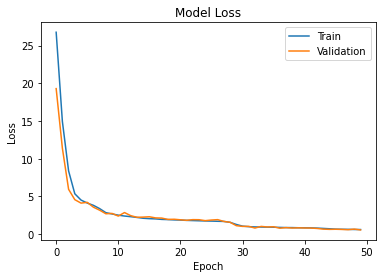

In [111]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [91]:
loss = model.evaluate([partial_test_reshape, categorical_test_reshape], y_test_reshape)
print(f"Test Loss (Haversine Distance): {loss}")


4311/4311 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 0.5605
Test Loss (Haversine Distance): 0.5588311553001404


In [92]:
predictions = model.predict([partial_test_reshape, categorical_test_reshape])
# Print or analyze the predictions
print(predictions)


4311/4311 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
[[ 2.2948792  -6.309898  ]
 [ 0.01899625  0.16105491]
 [ 0.02402772  0.16075578]
 ...
 [ 0.05271508  0.16069661]
 [ 0.0264755   0.16378634]
 [ 0.01094702  0.16553876]]


In [101]:
y_predicted=scaler.inverse_transform(predictions)

In [102]:
y_predicted

array([[  47.643932, -122.706024],
       [  39.95965 ,  116.33522 ],
       [  39.976635,  116.324165],
       ...,
       [  40.073498,  116.32198 ],
       [  39.9849  ,  116.43612 ],
       [  39.932472,  116.500854]], dtype=float32)

In [107]:
y_actual=scaler.inverse_transform(y_test)
print(y_actual)

[[  47.6122233  -122.1976416 ]
 [  39.95437     116.35537833]
 [  39.9755      116.3305283 ]
 ...
 [  40.0759083   116.3233049 ]
 [  40.01193     116.5614783 ]
 [  39.9267083   116.4712833 ]]


In [109]:
import numpy as np

def haversine(coord1, coord2):
    # Radius of the Earth in kilometers
    R = 6371.0  
    
    # Convert latitude and longitude from degrees to radians
    lat1, lon1 = np.radians(coord1)
    lat2, lon2 = np.radians(coord2)
    
    # Compute differences between coordinates
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # Haversine formula
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    # Distance in kilometers
    distance = R * c
    return distance

prediction=[  39.976635,  116.324165]
true=[  39.9755   ,   116.3305283 ]

# Calculate Haversine distance
distance = haversine(prediction, true)
print(f"The Haversine distance is: {distance:.2f} km")


The Haversine distance is: 0.56 km


In [112]:
import folium


# Create a map centered around the midpoint of the two points
midpoint = [(prediction[0] + true[0]) / 2, (prediction[1] + true[1]) / 2]
mymap = folium.Map(location=midpoint, zoom_start=6)

# Add markers for the two points
folium.Marker(location=prediction, popup="prediction", icon=folium.Icon(color='blue')).add_to(mymap)
folium.Marker(location=true, popup="true", icon=folium.Icon(color='red')).add_to(mymap)

# Draw a line between the two points
folium.PolyLine(locations=[prediction, true], color='green', weight=5, opacity=0.8).add_to(mymap)

# Display the map
mymap

In [113]:
import folium

# Example data: lists of prediction and true points (latitude, longitude)
predictions = [( 47.643932, -122.706024), (  39.95965 ,  116.33522 ), (  39.976635,  116.324165), (  39.932472,  116.500854)]
truths = [(  47.6122233 , -122.1976416 ), (  39.95437  ,   116.35537833), (  39.9755    ,  116.3305283 ), (  39.9267083 ,  116.4712833 )]

# Create a map centered at an initial location, you can set any default coordinates
mymap = folium.Map(location=[20.0, 0.0], zoom_start=2)

# Add markers for the prediction points
for i, pred in enumerate(predictions):
    folium.Marker(location=pred, popup=f"Prediction {i+1}", icon=folium.Icon(color='blue')).add_to(mymap)

# Add markers for the true points
for i, true in enumerate(truths):
    folium.Marker(location=true, popup=f"True {i+1}", icon=folium.Icon(color='red')).add_to(mymap)

# Draw lines between prediction and true points
for pred, true in zip(predictions, truths):
    folium.PolyLine(locations=[pred, true], color='green', weight=5, opacity=0.8).add_to(mymap)

# Display the map
mymap


In [114]:
df.to_excel('C:/Users/z044971/OneDrive - Alliance/vehicle_destination/geolife.xlsx', index=False)

In [115]:
tid_count=df['tid'].value_counts()

In [118]:
lis=[]
for i in tid_count:
    if(i<10):
        lis.append(i)

In [120]:
len(lis)

569

In [122]:
tid_count

Data\078_93      6995
Data\126_825     3952
Data\167_1309    3952
Data\084_987     3890
Data\084_980     3744
                 ... 
Data\021_144        1
Data\115_260        1
Data\115_233        1
Data\115_232        1
Data\128_1197       1
Name: tid, Length: 2535, dtype: int64